# Ringdown analyses

## Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import pystan
import seaborn as sns
import utils
import arviz as az
import corner
from sklearn.neighbors import KernelDensity
from scipy.interpolate import interp2d

sns.set(style='ticks', context='notebook', font='serif', 
        font_scale=1.5, palette='deep')
plt.rcParams["text.usetex"] = "true"
numpy.random.seed(1234)

## Preprocessing

Set some global settings:

In [3]:
test = 'rin'

# Input directory for individual samples from each run
input_paths_dict = {
    'pseob': '/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{par}.dat.gz',
    'pseobO3a': '/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{par}.dat.gz',
}

events_dict = {
    'pseob': ['GW150914', 'GW170104', 'S190519bj','S190521r','S190630ag','S190828j', 'S190910s'],
    #'pseobO3a': ['S190519bj','S190521r','S190630ag','S190828j', 'S190910s']
    'pseobO3a': ['S190519bj','S190521r','S190910s']


}

params_dict = {
    'pseob': ['domega_220', 'dtau_220'],
    'pseobO3a': ['domega_220', 'dtau_220'],
}

LOAD_CACHE = False
FORCE_LOAD_DATA = True

## Hierarchical combination

If previous results not found in disk, load `stan` model and fit it, looping over both ringdown analyses (`pyring` and `pseob`), whose parameters and events are defined above.

In [4]:
fits_dict = {}
data = {}

for run, input_path in input_paths_dict.items():
    print("Fitting run: %s\n-------------" % run)
    
    # Names of parameters (used to load files)
    params = params_dict[run]
    
    # Define cache path and create dir if needed
    cache_path = os.path.join('../cache/', test, run, '{par}_{hyper}.txt.gz')
    cache_dir = os.path.dirname(cache_path)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
        print("Created: %r" % cache_dir)

    # Attempt to load data and/or cached fit results
    data[run], fits, paths = utils.load_data_fits(params, input_path,
                                             cache=cache_path if LOAD_CACHE else '',
                                             force_load_data=FORCE_LOAD_DATA)
    for param, samp_dict in data[run].items():
        print("Loaded %r samples from %i events." % (param, len(samp_dict)))
    
    loaded_cache = all([p in fits for p in params])
    
    # purge parameters for which no data was found
    params = [p for p in params if len(data[run][p])>0]
    for p in data[run].keys():
        data[run] = {k: v for k,v in data[run].items() if p in params}
        fits = {k: v for k,v in fits.items() if p in params}
        paths = {k: v for k,v in paths.items() if p in params}

    # only some events are good for combining, remove the rest
    if events_dict[run] is not None:
        for p in data[run].keys():
            for d in [data[run], paths]:
                if p in d:
                    d[p] = {k: v for k,v in d[p].items() if k in events_dict[run]}
            print("Kept %r samples from %i events." % (p, len(data[run][p])))

    # If population fit not pre-loaded from disk, load Stan model and fit it.
    try:
        if model is None and not all([p in fits for p in params]):
            model = pystan.StanModel(file='hierGRtest.stan')
    except NameError:
        if not all([p in fits for p in params]):
            model = pystan.StanModel(file='hierGRtest.stan')
        else:
            # no need to load model because fits cached
            model = None
            
    # Fit it! (only if needed: `fit_all` checks whether fit already exists)
    fits = utils.fit_all(data[run], fits=fits, model=model, cache=cache_path)
    if cache_path and not loaded_cache:
        utils.save_cache(fits, cache_path, paths=paths)
    fits_dict[run] = fits

Fitting run: pseob
-------------


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_170ba1c77bece6c3fe4940215936cfda NOW.


Loaded 'domega_220' samples from 10 events.
Loaded 'dtau_220' samples from 10 events.
Kept 'domega_220' samples from 7 events.
Kept 'dtau_220' samples from 7 events.


/Users/richardbrito/Desktop/Projects/spinqnm/hierarchical_scripts/utils.py:182: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chi_samples = np.array(list(chi_samples_dict.values()))


Cached domega_220
Cached dtau_220
Events logged: '../cache/rin/pseob/events.json'
Fitting run: pseobO3a
-------------
Loaded 'domega_220' samples from 10 events.
Loaded 'dtau_220' samples from 10 events.
Kept 'domega_220' samples from 3 events.
Kept 'dtau_220' samples from 3 events.


Cached domega_220
Cached dtau_220
Events logged: '../cache/rin/pseobO3a/events.json'


## Summary stats

In [6]:
for run, fits in fits_dict.items():
    print('##################################')
    print('Run: %s' % run)
    hyper_ci_dict = utils.get_hyper_summary(fits)
    print()

##################################
Run: pseob
Hyperparameter constraints (90% CL)
----------------------------------
domega_220 (x1)
	mu:	0.03 +0.06 -0.05  [0.11]
	sigma: < 0.09
dtau_220 (x1)
	mu:	0.11 +0.21 -0.19  [0.40]
	sigma: < 0.39

##################################
Run: pseobO3a
Hyperparameter constraints (90% CL)
----------------------------------
domega_220 (x1)
	mu:	0.03 +0.16 -0.17  [0.33]
	sigma: < 0.35
dtau_220 (x1)
	mu:	0.17 +0.50 -0.42  [0.92]
	sigma: < 0.85



The inferred population distribution for each parameter given the events to date.
(If GR is correct this should be a $\delta$-function.).
This is our inference for the distribution of allowed deviations from GR.

In [7]:
for run, fits in fits_dict.items():
    print('##################################')
    print('Run: %s' % run)
    draws = utils.draw_population(fits, params=params_dict[run])
    ci_dict = utils.get_pop_summary(draws)
    print()

##################################
Run: pseob
Symmetric 90%-credible interval
--------------------------------
domega_220 (x1):	0.03 +0.10 -0.09	[0.20]
dtau_220 (x1):	0.10 +0.44 -0.39	[0.83]

##################################
Run: pseobO3a
Symmetric 90%-credible interval
--------------------------------
domega_220 (x1):	0.03 +0.33 -0.35	[0.68]
dtau_220 (x1):	0.16 +0.97 -0.87	[1.85]



## Plots

domega_220


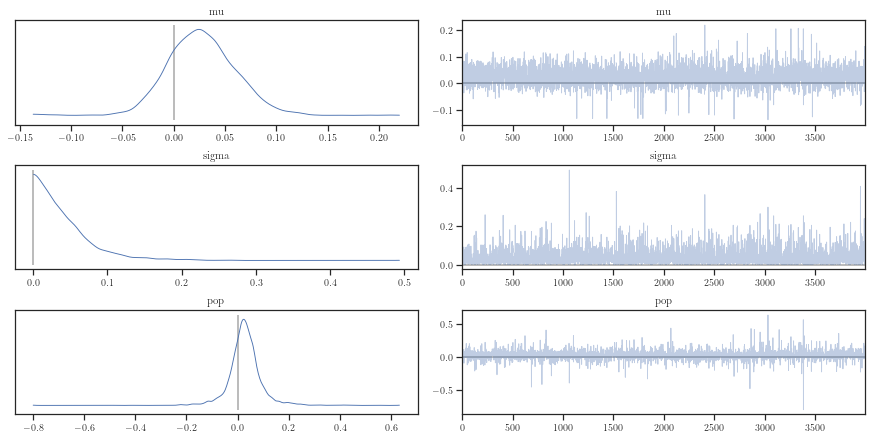

In [11]:
print('domega_220')
fit = fits_dict['pseob']['domega_220']
truth_lines = [(k, {}, 0) for k in ['mu', 'sigma', 'pop']]
az.plot_trace(fit, lines=truth_lines);

dtau_220


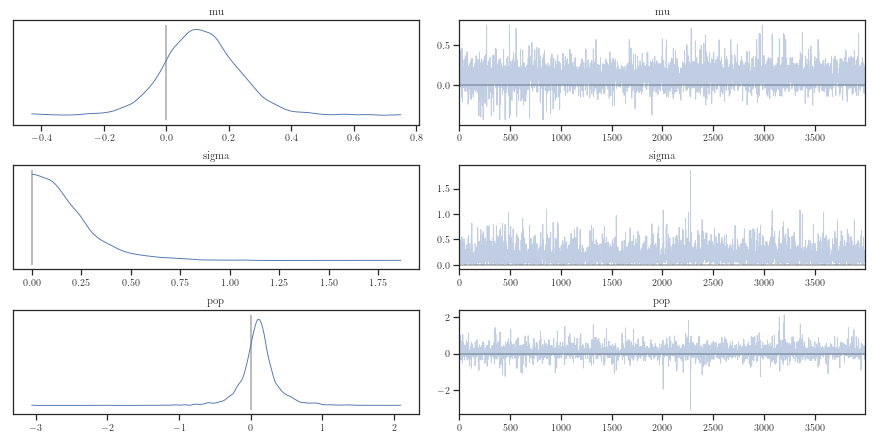

In [12]:
print('dtau_220')
fit = fits_dict['pseob']['dtau_220']
truth_lines = [(k, {}, 0) for k in ['mu', 'sigma', 'pop']]
az.plot_trace(fit, lines=truth_lines);

In [13]:
def get_label(k):
    p = k.split('_')[0][1:].replace('omega', 'f').replace('tau', r'\tau')
    lmn = k.split('_')[1]
    return r'$\delta %s_{%s}$' % (p, lmn)

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


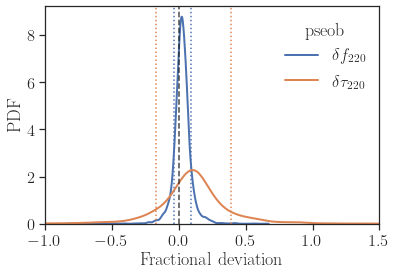

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


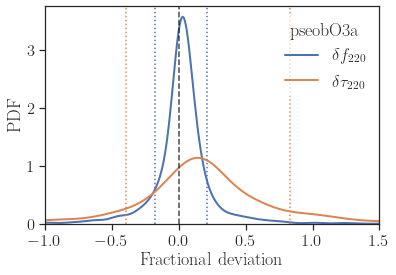

In [14]:
for run, fits in fits_dict.items():
    xlim = [-1,1.5]
    for i, param in enumerate(params_dict[run]):
        c = sns.color_palette()[i]
        l = get_label(param)
        x = fits[param]['pop']
        sns.distplot(x, label=l, hist=False,
                     kde_kws={'gridsize': 500, 'lw': 2},
                     hist_kws={'range': xlim}, color=c)
        gca().axvline(percentile(x, 10), ls=':', c=c)
        gca().axvline(percentile(x, 90), ls=':', c=c)
    gca().axvline(0, c='k', ls='--', alpha=0.8)
    plt.xlim(*xlim)
    plt.xlabel(r'Fractional deviation')
    plt.ylabel('PDF')
    plt.legend(framealpha=0.7, edgecolor='w', title=run)
    plt.show()

## Comparison with O3a

In [15]:
O3adomega220=np.loadtxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/hierarchical/pseob/domega_220_pop.txt.gz')
O3adtau220=np.loadtxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/hierarchical/pseob/dtau_220_pop.txt.gz')

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

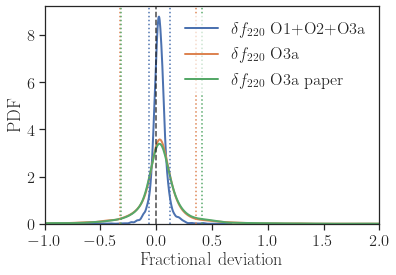

In [16]:
xlim = [-1, 2]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

l0 = r'$\delta f_{220}$ O1+O2+O3a'
l1 = r'$\delta f_{220}$ O3a'
l2 = r'$\delta f_{220}$ O3a paper'

x0 = fits_dict['pseob']['domega_220']['pop']
x1 = fits_dict['pseobO3a']['domega_220']['pop']
x2=  O3adomega220

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)
sns.distplot(x2, label=l2, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c2)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(percentile(x2, 5), ls=':', c=c2)
gca().axvline(percentile(x2, 95), ls=':', c=c2)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

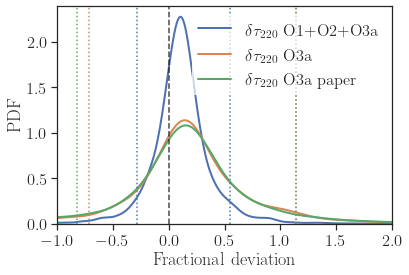

In [17]:
xlim = [-1, 2]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

l0 = r'$\delta \tau_{220}$ O1+O2+O3a'
l1 = r'$\delta \tau_{220}$ O3a'
l2 = r'$\delta \tau_{220}$ O3a paper'

x0 = fits_dict['pseob']['dtau_220']['pop']
x1 = fits_dict['pseobO3a']['dtau_220']['pop']
x2=  O3adtau220

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)
sns.distplot(x2, label=l2, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c2)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(percentile(x2, 5), ls=':', c=c2)
gca().axvline(percentile(x2, 95), ls=':', c=c2)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

## Multiplying likelihoods ("restricted combination")

In [19]:
data['pseobO3a']['domega_220'].keys()

dict_keys(['S190519bj', 'S190521r', 'S190910s'])

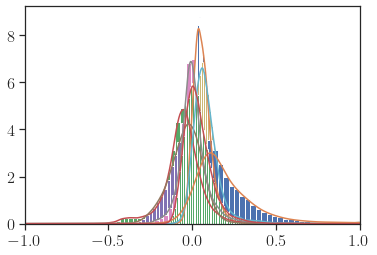

In [22]:
for event in data['pseob']['domega_220'].keys():

    data0=data['pseob']['domega_220'][event]

    plt.hist(data0, bins=80,density=True) 
    x =  np.linspace(-1,1,1000)[:, np.newaxis]

    bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
    log_dens0 = kde0.score_samples(x)

    plt.plot(x,np.exp(log_dens0))

    plt.xlim([-1.0,1.0])

plt.show()

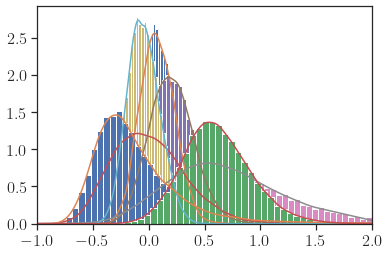

In [21]:
for event in data['pseob']['dtau_220'].keys():

    data0=data['pseob']['dtau_220'][event]

    plt.hist(data0, bins=50,density=True) 
    x =  np.linspace(-1,2,1000)[:, np.newaxis]

    bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
    log_dens0 = kde0.score_samples(x)

    plt.plot(x,np.exp(log_dens0))

    plt.xlim([-1,2])

plt.show()

In [23]:
for event in data['pseob']['domega_220'].keys():
    
        print(max(data['pseob']['domega_220'][event]))

0.5082138000458104
1.2750232717464485
1.2809288668320324
1.9000994768540391
0.8235213120481676
1.9981209734932843
0.6665451299920063


In [24]:
x =  np.linspace(-0.9,2.0, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0] #[0]*len(x)

for event in data['pseob']['domega_220'].keys():
    
        data0=data['pseob']['domega_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)
    
prob=np.exp(log_dens)
comb_domega220=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

In [25]:
x =  np.linspace(-0.9,2.0, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0] #[0]*len(x)

for event in data['pseobO3a']['domega_220'].keys():
    
        data0=data['pseobO3a']['domega_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)
    
prob=np.exp(log_dens)
comb_domega220_O3a=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

In [26]:
for event in data['pseob']['dtau_220'].keys():
    
        print(max(data['pseob']['dtau_220'][event]))

0.6965417009162703
1.6719540382879865
1.2588436836700834
1.9999095211192293
0.6342198566132196
1.9977561790625296
2.461509383018356


In [27]:
x =  np.linspace(-0.9,2.5, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0]

for event in data['pseob']['dtau_220'].keys():
    
        data0=data['pseob']['dtau_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)

prob=np.exp(log_dens)
comb_dtau220=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

In [28]:
x =  np.linspace(-0.9,2.5, 10000)[:, np.newaxis]

log_dens = np.zeros_like(x).T[0]

for event in data['pseobO3a']['dtau_220'].keys():
    
        data0=data['pseobO3a']['dtau_220'][event]
        
        bw = 1.06 * data0.std() * data0.size ** (-1 / 5.) #Silverman's rule of thumb
        kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data0.reshape(-1, 1))
        log_dens += kde.score_samples(x)

prob=np.exp(log_dens)
comb_dtau220_O3a=np.random.choice(x[:,0], 10000,p=prob/(sum(prob)))

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


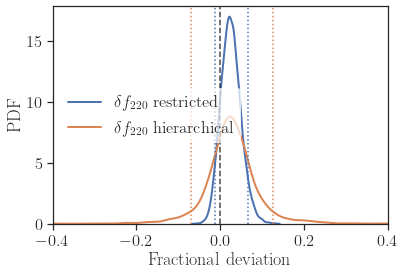

In [31]:
xlim = [-0.4, 0.4]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta f_{220}$ restricted'
l1 = r'$\delta f_{220}$ hierarchical'
x0 = comb_domega220 #fits['domega_220']['pop'][fits['domega_220']['sigma']<0.01]
x1 = fits_dict['pseob']['domega_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


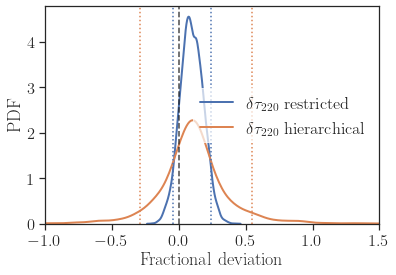

In [32]:
xlim = [-1, 1.5]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]

l0 = r'$\delta \tau_{220}$ restricted'
l1 = r'$\delta \tau_{220}$ hierarchical'

x0 = comb_dtau220  #fits['dtau_220']['pop'][fits['dtau_220']['sigma']<0.05]
x1 = fits_dict['pseob']['dtau_220']['pop']

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)

gca().axvline(percentile(x0, 5), ls=':', c=c0)
gca().axvline(percentile(x0, 95), ls=':', c=c0)
gca().axvline(percentile(x1, 5), ls=':', c=c1)
gca().axvline(percentile(x1, 95), ls=':', c=c1)
gca().axvline(0, c='k', ls='--', alpha=0.8)
plt.xlim(*xlim)
plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w')
plt.show()

In [34]:
np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{par}_comb.dat.gz'.format(par='domega_220'),comb_domega220)
np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{par}_comb.dat.gz'.format(par='dtau_220'),comb_dtau220)

np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{par}_comb_O3a.dat.gz'.format(par='domega_220'),comb_domega220_O3a)
np.savetxt('/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{par}_comb_O3a.dat.gz'.format(par='dtau_220'),comb_dtau220_O3a)


## Summary statistics

In [5]:
# Load samples first
# A list of events
event_list = ['GW150914', 'GW170104', 'S190519bj','S190521r','S190630ag','S190828j', 'S190910s']
params= ['domega_220', 'dtau_220']

data_file_path_template = "/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{param}.dat.gz"
sample_dict = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_file_path_template.format(event=event, param=param))

#hierarchical results
domega220_hier = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_pop.dat.gz".format(param="domega_220"))
dtau220_hier = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_pop.dat.gz".format(param="dtau_220"))

#joint likelihood results
domega220_comb = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_comb.dat.gz".format(param="domega_220"))
dtau220_comb = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_comb.dat.gz".format(param="dtau_220"))


In [11]:
def ComputeSymCIedges(samples, ci=0.9):
    """ Symmetric CI.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi, lo

# ----------------------------------------------------------------------------
# Summary
# ----------------------------------------------------------------------------


def get_summary(samples, p=0.9):
    ci_dict = {}
    print("Symmetric {}%-credible interval".format(int(p*100)))
    print("--------------------------------")
    ci1, ci2 = ComputeSymCIedges(np.array(samples), p)
    med = np.median(np.array(samples))
    return print('\t%.2f +%.2f -%.2f\t[%.2f]' % (med, ci1-med, med-ci2, ci1-ci2))

In [8]:
print('Summary for hierarchical inference:\n')
get_summary(domega220_hier)
get_summary(dtau220_hier)
print('\n--------------------------------\n')
print('Summary for joint likelihodd:\n')
get_summary(domega220_comb)
get_summary(dtau220_comb)
print('\n--------------------------------\n')
print('Summary for GW150914\n')
get_summary(sample_dict["domega_220"]['GW150914'])
get_summary(sample_dict["dtau_220"]['GW150914'])
#print('\n--------------------------------\n')
#print('Summary for S190521r\n')
#get_summary(sample_dict["domega_220"]['S190521r'])
#get_summary(sample_dict["dtau_220"]['S190521r'])

Summary for hierarchical inference:

Symmetric 90%-credible interval
--------------------------------
	0.03 +0.10 -0.09	[0.20]
Symmetric 90%-credible interval
--------------------------------
	0.10 +0.44 -0.39	[0.83]

--------------------------------

Summary for joint likelihodd:

Symmetric 90%-credible interval
--------------------------------
	0.02 +0.04 -0.04	[0.08]
Symmetric 90%-credible interval
--------------------------------
	0.10 +0.14 -0.14	[0.28]

--------------------------------

Summary for GW150914

Symmetric 90%-credible interval
--------------------------------
	0.05 +0.11 -0.07	[0.17]
Symmetric 90%-credible interval
--------------------------------
	0.07 +0.26 -0.23	[0.49]


## plotting all together

749


/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

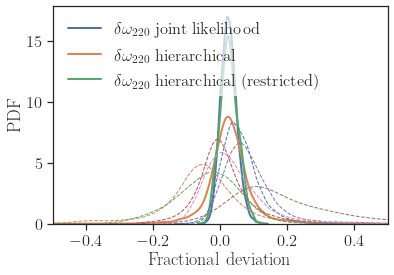

In [55]:
xlim = [-1, 1]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

l0 = r'$\delta \omega_{220}$ joint likelihood'
l1 = r'$\delta \omega_{220}$ hierarchical'
l2 = r'$\delta \omega_{220}$ hierarchical (restricted)'

x0 = comb_domega220
x1 = fits_dict['pseob']['domega_220']['pop']
x2 = fits_dict['pseob']['domega_220']['pop'][fits_dict['pseob']['domega_220']['sigma']<.01]
print(len(x2))

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c1)
sns.distplot(x2, label=l2, hist=False,kde_kws={'gridsize': 500, 'lw': 2},hist_kws={'range': xlim}, color=c2)


for event in data['pseob']['domega_220'].keys():

    data0=data['pseob']['domega_220'][event]

    sns.distplot(data0, hist=False,kde_kws={'lw': 1,'linestyle':'--'}) 

plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w',loc='upper left')
plt.xlim([-0.5,0.5])
plt.show()

729


/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

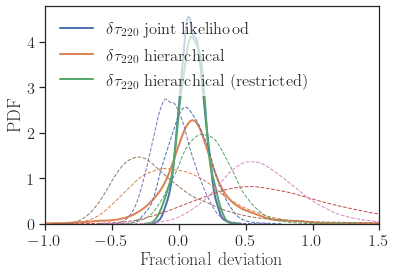

In [52]:
xlim = [-1, 1.5]

c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

l0 = r'$\delta \tau_{220}$ joint likelihood'
l1 = r'$\delta \tau_{220}$ hierarchical'
l2 = r'$\delta \tau_{220}$ hierarchical (restricted)'
x0 = comb_dtau220
x1 = fits_dict['pseob']['dtau_220']['pop']
x2 = fits_dict['pseob']['dtau_220']['pop'][fits_dict['pseob']['dtau_220']['sigma']<.05]
print(len(x2))

sns.distplot(x0, label=l0, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c0)
sns.distplot(x1, label=l1, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c1)
sns.distplot(x2, label=l2, hist=False,kde_kws={'gridsize': 500, 'lw': 2}, color=c2)

for event in data['pseob']['dtau_220'].keys():

    data0=data['pseob']['dtau_220'][event]

    sns.distplot(data0, hist=False,kde_kws={'lw': 1,'linestyle':'--'}) 

plt.xlabel(r'Fractional deviation')
plt.ylabel('PDF')
plt.legend(framealpha=0.7, edgecolor='w',loc='upper left')
plt.xlim([*xlim])
plt.show()

## Joint likelihood (2D)

In [4]:
# Load samples first
# A list of events
event_list = ['GW150914', 'GW170104', 'S190519bj','S190521r','S190630ag','S190828j', 'S190910s']
params= ['domega_220', 'dtau_220']

data_path = "/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{param}.dat.gz"
sample_dict = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_path.format(event=event, param=param))
        
        

In [134]:
def kde2D(x, y, bandwidth, xbins=200j, ybins=200j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations
    #xx, yy = np.mgrid[x.min():x.max():xbins, 
    #                  y.min():y.max():ybins]

    xx, yy = np.mgrid[-0.2:0.2:xbins, 
                      -0.5:0.5:ybins]
  
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(kernel='gaussian', bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [135]:
def get_marginalized_posteriors(L_domega_dtau,domega_vec,dtau_vec):
    # Normalize the 2D posteriors
    dx = np.mean(np.diff(domega_vec))
    dy = np.mean(np.diff(dtau_vec))
    L_domega_dtau /= np.sum(L_domega_dtau) * dx * dy

    # Compute marginalized 1D posterior
    L_domega      = np.sum(L_domega_dtau, axis=0) * dy
    L_dtau  = np.sum(L_domega_dtau, axis=1) * dx
    L_domega     /= np.sum(L_domega) * dx
    L_dtau /= np.sum(L_dtau) * dy
    
    return L_domega_dtau, L_domega, L_dtau, dx, dy

def multiply_likelihoods(events, **kws):
    # Initialize joint likelihood: *_joint
    L_joint     = np.ones((kws['N_bins'], kws['N_bins']))

    for event in events:

        # produce the likelihood data for this event, and corresponding grid
        bw=1.0 * sample_dict['domega_220'][event].std() * sample_dict['domega_220'][event].size ** (-1 / 6.)
        domega_vec, dtau_vec, L_domega_dtau = kde2D(sample_dict['domega_220'][event], sample_dict['dtau_220'][event], bw)

        # Construct likelihood interpolation object
        L_domega_dtau_interp_obj = interp2d(domega_vec.T.flatten(),dtau_vec.T.flatten(),L_domega_dtau.T.flatten(),
                                                    fill_value=0.0,
                                                    bounds_error=False)
        # Interpolate all events to a common grid
        #domega_vec           = np.linspace(-0.9, 2.0, kws['N_bins'])
        #dtau_vec       = np.linspace(-0.9,2.5, kws['N_bins'])
        domega_vec           = np.linspace(-0.2, 0.2, kws['N_bins'])
        dtau_vec       = np.linspace(-0.5,0.5, kws['N_bins'])
        L_domega_dtau = L_domega_dtau_interp_obj(domega_vec,dtau_vec)

        #dx = np.mean(np.diff(domega_vec))
        #dy = np.mean(np.diff(dtau_vec))
        # Get marginalized 1D posteriors and normalized 2D posteriors
        L_domega_dtau, _, _, dx, dy = get_marginalized_posteriors(L_domega_dtau,domega_vec,dtau_vec)

        # Joint likelihood for *all* events
        L_joint *= L_domega_dtau

        # Removing nans and inf, normalizing the joint posterior
        L_joint[np.isnan(L_joint)] = 0.
        L_joint[np.isinf(L_joint)] = 0.
        L_joint[L_joint<0] = 0.
        L_joint /= np.sum(L_joint) * dx * dy

    # ~~~~~~~~~~~~ Marginalization to one-dimensional joint_posteriors
    L_domega_joint      = np.sum(L_joint, axis=0) * dy
    L_dtau_joint  = np.sum(L_joint, axis=1) * dx

    # ~~~~~~~~~~~~ Normalisation of marginalized posteriors
    L_domega_joint     /= np.sum(L_domega_joint) * dx
    L_dtau_joint /= np.sum(L_dtau_joint) * dy

    return L_joint, L_domega_joint, L_dtau_joint, domega_vec, dtau_vec


In [136]:
settings = {'N_bins'    : 401,}

L_joint, L_domega_joint, L_dtau_joint, domega_vec, dtau_vec = multiply_likelihoods(event_list, **settings)



/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=222,184 m=40000 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=201,204 m=40000 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [137]:
rng = np.random.default_rng()
checkdomega=rng.choice(domega_vec, 10000,p=L_domega_joint/(sum(L_domega_joint)))
checkdtau=rng.choice(dtau_vec, 10000,p=L_dtau_joint/(sum(L_dtau_joint)))

In [138]:
L2D=L_joint.reshape(-1)
L2D/=L2D.sum() # it has to be normalized 

# generate the set of all x,y pairs represented by the pmf
array2D=np.vstack([domega_vec, dtau_vec]).T # here are all of the x,y pairs 

pairs=np.indices(dimensions=(len(domega_vec),len(domega_vec))).T
# make n random selections from the flattened pmf without replacement
# whether you want replacement depends on your application
n=10000 
inds=np.random.choice(np.arange(len(domega_vec)**2),n,p=L2D)
selections=pairs.reshape(-1,2)[inds]

checkdomega2D=domega_vec[selections[:,0]]
checkdtau2D=dtau_vec[selections[:,1]]

In [139]:
get_summary(checkdomega)
get_summary(checkdtau)
get_summary(checkdomega2D)
get_summary(checkdtau2D)

Symmetric 90%-credible interval
--------------------------------
	0.03 +0.04 -0.04	[0.08]
Symmetric 90%-credible interval
--------------------------------
	0.11 +0.14 -0.13	[0.26]
Symmetric 90%-credible interval
--------------------------------
	0.03 +0.04 -0.04	[0.07]
Symmetric 90%-credible interval
--------------------------------
	0.11 +0.14 -0.12	[0.27]


In [140]:
#joint likelihood (in 1D) results
domega220_comb = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_comb.dat.gz".format(param="domega_220"))
dtau220_comb = np.loadtxt("/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/combined_samples/{param}_comb.dat.gz".format(param="dtau_220"))


/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

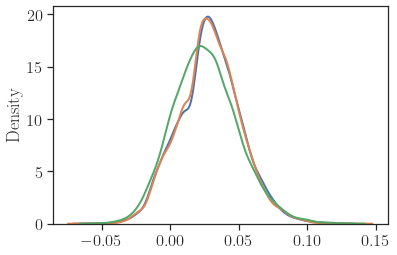

In [141]:
sns.distplot(checkdomega, hist=False, kde_kws={'gridsize': 500, 'lw': 2})
sns.distplot(checkdomega2D, hist=False, kde_kws={'gridsize': 500, 'lw': 2})
sns.distplot(domega220_comb, hist=False, kde_kws={'gridsize': 500, 'lw': 2})

plt.show()

/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/richardbrito/opt/anaconda3/envs/spinqnm_combine/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a fu

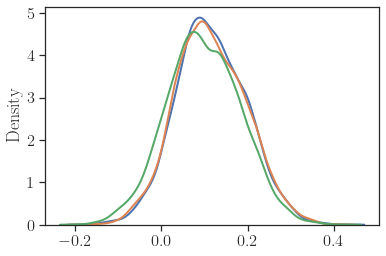

In [142]:
sns.distplot(checkdtau, hist=False, kde_kws={'gridsize': 500, 'lw': 2})
sns.distplot(checkdtau2D, hist=False, kde_kws={'gridsize': 500, 'lw': 2})
sns.distplot(dtau220_comb, hist=False, kde_kws={'gridsize': 500, 'lw': 2})

plt.show()

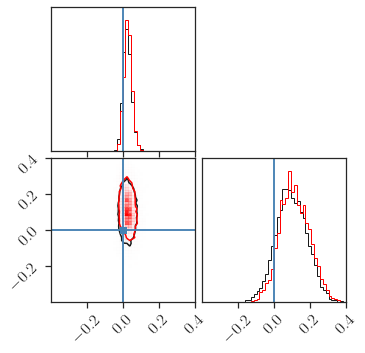

In [149]:
import corner

samples1D = np.vstack([domega220_comb, dtau220_comb]).T
samples2D = np.vstack([checkdomega2D, checkdtau2D]).T

figure = corner.corner(samples1D,range=[[-0.4, 0.4], [-0.4, 0.4]],
                       plot_datapoints=False,levels=[0.9],fill_contours=False,truths=[0,0],bins=50)

corner.corner(samples2D,range=[[-0.4, 0.4], [-0.4, 0.4]],color='red',
                       plot_datapoints=False,levels=[0.9],fill_contours=False,truths=[0,0],bins=50,
             fig=figure)

plt.show()

## Comparison with pEOB

In [18]:
# Load samples first
# A list of events
event_list = ['GW150914', 'GW170104', 'S190519bj','S190521r','S190630ag','S190828j', 'S190910s']
params= ['freq_220', 'tau_220']

data_path = "/Users/richardbrito/Desktop/Projects/spinqnm/data/rin/{event}/rin_{event}_pseobnrv4hm_{param}_modGR.dat.gz"

sample_dict = {}
sample_dict2 = {}
for param in params:
    sample_dict[param] = {}
    for event in event_list:
        sample_dict[param][event] = np.loadtxt(data_path.format(event=event, param=param))

data_pEOB='/Users/richardbrito/Desktop/Projects/spinqnm/data/GW150914/Fig2/pEOB.dat'
pEOB=np.loadtxt(data_pEOB.format(event=event, param=param))

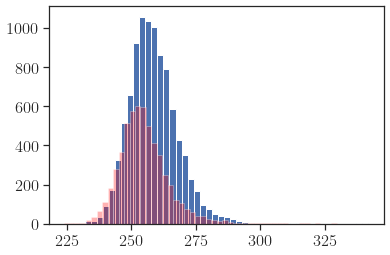

In [38]:
plt.hist(sample_dict['freq_220']['GW150914'],bins=50)
plt.hist(pEOB[:,0],bins=50,color='red',alpha=0.3)

plt.show()

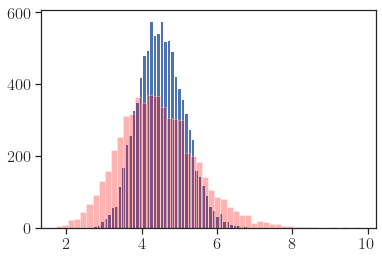

In [39]:
plt.hist(1000*sample_dict['tau_220']['GW150914'],bins=50)
plt.hist(pEOB[:,1],bins=50,color='red',alpha=0.3)

plt.show()